#### 訓練資料
在 https://www.dropbox.com/scl/fi/jv072cyo3y62f6ykw54l8/dataset1.zip?rlkey=mf1tmtrnd6ys7m7oi4ygtcro9&st=vj8bwlik&dl=1

覺得很麻煩就不用程式下載了，自己去抓就好

In [1]:
import torch
import os, cv2, random, glob
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms, models, datasets
from torchvision.ops import nms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import warnings
import configparser
from random import randint
warnings.filterwarnings('ignore')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

In [3]:
# Load configuration
config = configparser.ConfigParser()
config.read('config.ini')
# Load parameters from config file
root = '/Users/leonjye/Documents/MachineLearingData'
#root = config.get('DEFAULT', 'root_dir')
IMAGE_ROOT = os.path.join(root, 'dataset1')

In [4]:
class SegData(Dataset):
    def __init__(self, image_dir=IMAGE_ROOT, split='train'):
        self.w = 224
        self.h = 224
        self.image_dir = os.path.join(image_dir, f'images_prepped_{split}')
        self.mask_dir = os.path.join(image_dir, f'annotations_prepped_{split}')
        self.items = [os.path.splitext(os.path.basename(x))[0] for x in glob.glob(f'{self.image_dir}/*.png')]
        #self.items = self.stems(f'dataset1/images_prepped_{split}')
        self.split = split
    def __len__(self):
        return len(self.items)
    def __getitem__(self, ix):
        img_path = f'{self.image_dir}/{self.items[ix]}.png'
        image = Image.open(img_path).convert("RGB")
        image = np.array(image.resize((self.w, self.h), resample=Image.BILINEAR))
        mask_path = f'{self.mask_dir}/{self.items[ix]}.png'
        mask = Image.open(mask_path).convert("L")
        mask = np.array(mask.resize((self.w, self.h), resample=Image.NEAREST))
        #mask = cv2.imread(f'{self.mask_dir}/{self.items[ix]}.png', cv2.IMREAD_GRAYSCALE)
        #mask = cv2.resize(mask, (224,224))
        return image, mask
    
    def choose(self): return self[random.randint(0, len(self))-1]

    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([transform(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

In [5]:
trn_ds = SegData(image_dir=IMAGE_ROOT, split='train')
val_ds = SegData(image_dir=IMAGE_ROOT, split='test')
trn_dl = DataLoader(trn_ds, batch_size=8, shuffle=True,
collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=4, shuffle=True,
collate_fn=val_ds.collate_fn)

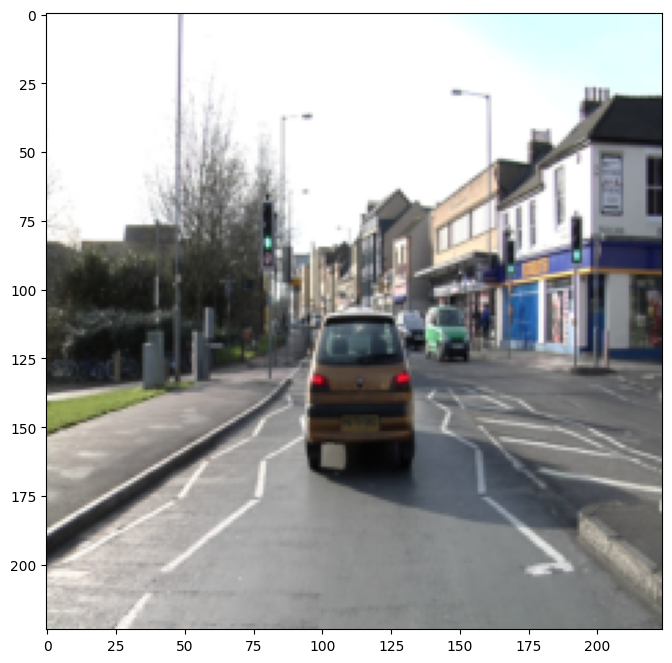

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.imshow(trn_ds.choose()[0])

In [7]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [8]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [9]:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()

        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

In [10]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [11]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [12]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 1

In [13]:
for epoch in range(n_epochs):
    _n = len(trn_dl)
    for ix, inputs in enumerate(trn_dl):
        loss, acc = train_batch(model, inputs, optimizer, criterion)
        print(f"Epoch {epoch+1}/{n_epochs}, Batch {ix+1}/{_n}, Loss: {loss}, acc: {acc}")
    _n = len(val_dl)
    for ix,inputs in enumerate(val_dl):
        loss, acc  = validate_batch(model, inputs, criterion)
        print(f"Epoch {epoch+1}/{n_epochs}, Batch {ix+1}/{_n}, Loss: {loss}, acc: {acc}")
    
torch.save(model.state_dict(), '09_1_UNet_ImageSeq.pth')

Epoch 1/1, Batch 1/46, Loss: 2.4780967235565186, acc: 0.10678660869598389
Epoch 1/1, Batch 2/46, Loss: 2.2270848751068115, acc: 0.3178636133670807
Epoch 1/1, Batch 3/46, Loss: 2.074540138244629, acc: 0.46987852454185486
Epoch 1/1, Batch 4/46, Loss: 1.974491834640503, acc: 0.5398322939872742
Epoch 1/1, Batch 5/46, Loss: 1.8082494735717773, acc: 0.6269979476928711
Epoch 1/1, Batch 6/46, Loss: 1.7402479648590088, acc: 0.6570496559143066
Epoch 1/1, Batch 7/46, Loss: 1.6501778364181519, acc: 0.706318736076355
Epoch 1/1, Batch 8/46, Loss: 1.5894027948379517, acc: 0.7086181640625
Epoch 1/1, Batch 9/46, Loss: 1.5695698261260986, acc: 0.7076365947723389
Epoch 1/1, Batch 10/46, Loss: 1.5650575160980225, acc: 0.6941640377044678
Epoch 1/1, Batch 11/46, Loss: 1.5426908731460571, acc: 0.6783472299575806
Epoch 1/1, Batch 12/46, Loss: 1.5669926404953003, acc: 0.6979556679725647
Epoch 1/1, Batch 13/46, Loss: 1.5125728845596313, acc: 0.7119863033294678
Epoch 1/1, Batch 14/46, Loss: 1.4283552169799805, a

In [27]:
image_val, mask_val = val_ds.choose()
image_val = transform(image_val.copy()/255.).unsqueeze(0).float().to(device)
model.eval()
with torch.no_grad():
    pred_val = model(image_val)
    pred_val = torch.argmax(pred_val, dim=1).squeeze().cpu().numpy()
    mask_val = mask_val.squeeze()
    image_val = image_val.squeeze().cpu().numpy()
    image_val = np.transpose(image_val, (1, 2, 0))
    image_val = (image_val * 255).astype(np.uint8)
    image_val = cv2.cvtColor(image_val, cv2.COLOR_RGB2BGR)
    pred_val = cv2.resize(pred_val, (image_val.shape[1], image_val.shape[0]), interpolation=cv2.INTER_NEAREST)
    mask_val = cv2.resize(mask_val, (image_val.shape[1], image_val.shape[0]), interpolation=cv2.INTER_NEAREST)
    pred_val = np.array(pred_val, dtype=np.uint8)
    mask_val = np.array(mask_val, dtype=np.uint8)
    pred_val = cv2.cvtColor(pred_val, cv2.COLOR_GRAY2BGR)
    mask_val = cv2.cvtColor(mask_val, cv2.COLOR_GRAY2BGR)
    pred_val = cv2.addWeighted(image_val, 0.5, pred_val, 0.5, 0)
    mask_val = cv2.addWeighted(image_val, 0.5, mask_val, 0.5, 0)
    cv2.imshow('image', image_val)
    cv2.imshow('pred', pred_val)
    cv2.imshow('mask', mask_val)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
# Save the model

2025-04-21 23:38:09.978 python[32387:12410066] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-21 23:38:09.978 python[32387:12410066] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [ ]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)

image_outs = [
    im[0].permute(1,2,0).detach().cpu()[:,:,0], 
    mask.permute(1,2,0).detach().cpu()[:,:,0],
    _mask.permute(1,2,0).detach().cpu()[:,:,0]]

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

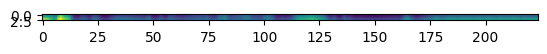

In [ ]:
plt.imshow(im[0])

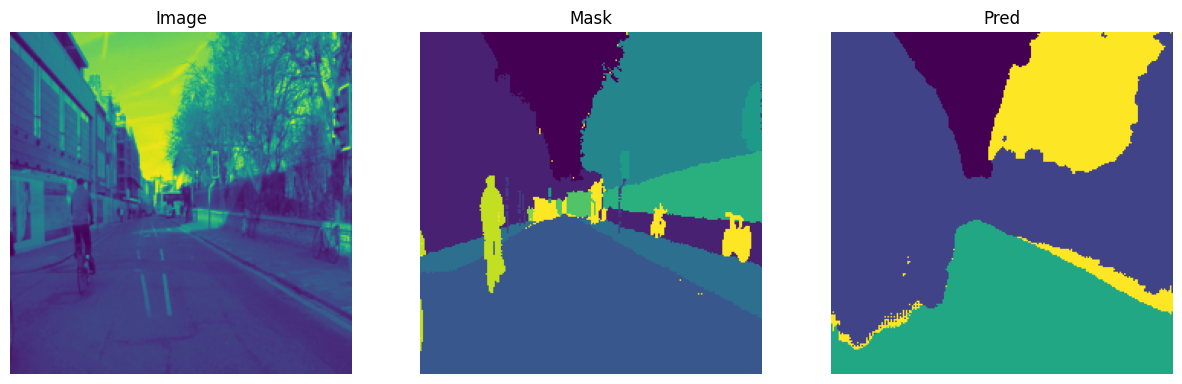

In [16]:
fig, ax = plt.subplots(1,3, figsize=(15,15))
for i in range(3):
    ax[i].imshow(image_outs[i])
    ax[i].set_title(['Image', 'Mask', 'Pred'][i])
    ax[i].axis('off')
plt.show()
fig.savefig('09_1_UNet_ImageSeq.png', dpi=300, bbox_inches='tight')